<a href="https://colab.research.google.com/github/paolala24/senales_sistemas/blob/main/parcial_2/punto2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Segundo punto:**

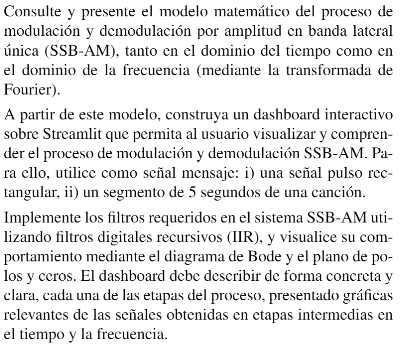

In [4]:
# 🔧 Instala Streamlit, librosa y descarga Cloudflared
!pip install streamlit librosa --quiet

# Descarga cloudflared (actualizado)
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared
!mv cloudflared /usr/local/bin/cloudflared


In [5]:
%%writefile 1_📊_SSB_AM_Dashboard.py
# Importamos las librerías necesarias
import streamlit as st  # Librería para crear dashboards web interactivos
import numpy as np  # Operaciones numéricas y manejo de arreglos
import matplotlib.pyplot as plt  # Gráficas
import librosa  # Procesamiento de señales de audio
import librosa.display  # Visualización de señales de audio
from scipy.signal import hilbert, butter, lfilter, freqz, tf2zpk  # Funciones de análisis y filtrado

# Función para generar un pulso rectangular
def rectangular_pulse(duration=1.0, fs=1000):
    t = np.linspace(0, duration, int(fs*duration), endpoint=False)  # Vector de tiempo
    pulse = np.ones_like(t)  # Pulso constante (valor 1)
    return t, pulse

# Función para cargar un fragmento de un archivo de audio
def load_audio_segment(path, duration=5):
    y, sr = librosa.load(path, duration=duration)  # Carga el audio
    return y, sr  # Retorna señal y frecuencia de muestreo

# Función para realizar la modulación SSB (Single Side Band)
def ssb_modulate(m, fs, fc=100):
    t = np.arange(len(m)) / fs  # Vector de tiempo
    mhilbert = np.imag(hilbert(m))  # Parte imaginaria de la transformada de Hilbert
    s = m * np.cos(2*np.pi*fc*t) - mhilbert * np.sin(2*np.pi*fc*t)  # Fórmula SSB
    return t, s

# Diseño de filtro pasa bajos de Butterworth
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyq  # Frecuencia de corte normalizada
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # Coeficientes del filtro
    return b, a

# Aplicación del filtro sobre una señal
def apply_filter(data, b, a):
    return lfilter(b, a, data)  # Aplica el filtro definido por b y a

# Título principal del dashboard
st.title("🛰️ Visualización de Modulación y Demodulación SSB-AM")

# Selección del tipo de señal de entrada
opcion = st.radio("Selecciona la señal mensaje:", ["Pulso rectangular", "Fragmento de canción (.wav)"])

fs = 1000  # Frecuencia de muestreo por defecto
if opcion == "Pulso rectangular":
    t, mensaje = rectangular_pulse()  # Genera el pulso
else:
    archivo = st.file_uploader("Carga un archivo de audio .wav", type=["wav"])  # Carga archivo .wav
    if archivo is not None:
        mensaje, fs = load_audio_segment(archivo)  # Carga el fragmento de audio
        t = np.arange(len(mensaje)) / fs  # Vector de tiempo correspondiente
    else:
        st.stop()  # Si no se sube un archivo, se detiene la ejecución

# Visualización de la señal mensaje
fig_msg, ax_msg = plt.subplots(facecolor='#0e1117')  # Fondo oscuro para la figura
if len(mensaje) > 2000:
    downsample_factor = len(mensaje) // 2000  # Reducir resolución si la señal es muy larga
    mensaje_vis = mensaje[::downsample_factor]
    t_vis = t[::downsample_factor]
else:
    mensaje_vis = mensaje
    t_vis = t
ax_msg.plot(t_vis, mensaje_vis, color='#00ffff', linewidth=0.8)  # Gráfica de la señal
ax_msg.set_title("📈 Señal Mensaje", color='white')
ax_msg.set_xlabel("Tiempo (s)", color='white')
ax_msg.set_ylabel("Amplitud", color='white')
ax_msg.tick_params(colors='white')
ax_msg.grid(True, color='gray')
st.pyplot(fig_msg)  # Muestra la gráfica en el dashboard
st.markdown("**📝 Descripción:** Esta es la señal original que se desea transmitir, ya sea una forma artificial como un pulso o un segmento de audio real.")

# Modulación SSB de la señal
t, ssb = ssb_modulate(mensaje, fs)  # Señal modulada
fig_mod, ax_mod = plt.subplots(facecolor='#0e1117')
ax_mod.plot(t, ssb, color='cyan')  # Gráfica de la señal modulada
ax_mod.set_title("📡 Señal Modulada SSB-AM", color='white')
ax_mod.set_xlabel("Tiempo (s)", color='white')
ax_mod.set_ylabel("Amplitud", color='white')
ax_mod.tick_params(colors='white')
ax_mod.grid(True, color='gray')
st.pyplot(fig_mod)
st.markdown("**📝 Descripción:** Resultado de aplicar modulación en banda lateral única. Solo se transmite una de las bandas laterales para ahorrar ancho de banda.")

# Filtrado tras demodulación
st.subheader("🔧 Señal Filtrada (post-demodulación)")
cutoff = st.slider("Frecuencia de corte del filtro (Hz)", 10, fs//2, 200)  # Control deslizante para cambiar la frecuencia de corte
b, a = butter_lowpass(cutoff, fs)  # Crea el filtro
filtered = apply_filter(ssb, b, a)  # Aplica el filtro
fig_filt, ax_filt = plt.subplots(facecolor='#0e1117')
ax_filt.plot(t, filtered, color='cyan')  # Gráfica de la señal filtrada
ax_filt.set_title("🔧 Señal Filtrada (post-demodulación)", color='white')
ax_filt.set_xlabel("Tiempo (s)", color='white')
ax_filt.set_ylabel("Amplitud", color='white')
ax_filt.tick_params(colors='white')
ax_filt.grid(True, color='gray')
st.pyplot(fig_filt)
st.markdown("**📝 Descripción:** Después de demodular, se aplica un filtro paso bajo para eliminar componentes de alta frecuencia y recuperar la señal original.")

# Diagrama de Bode del filtro
w, h = freqz(b, a, fs=fs)  # Respuesta en frecuencia del filtro
fig1, ax1 = plt.subplots()
ax1.semilogx(w, 20 * np.log10(np.abs(h)))  # Escala logarítmica en frecuencia
ax1.set_title("📉 Diagrama de Bode")
ax1.set_xlabel("Frecuencia (Hz)")
ax1.set_ylabel("Magnitud (dB)")
ax1.grid()
st.pyplot(fig1)
st.markdown("**📝 Descripción:** Muestra cómo responde el filtro en el dominio de la frecuencia. Ayuda a entender qué frecuencias son atenuadas o conservadas.")

# Plano de polos y ceros del filtro
z, p, k = tf2zpk(b, a)  # Obtiene ceros (z), polos (p) y ganancia (k)
fig2, ax2 = plt.subplots()
theta = np.linspace(0, 2*np.pi, 300)  # Círculo unitario para evaluar estabilidad
ax2.plot(np.cos(theta), np.sin(theta), 'k--', label='Círculo unitario')
ax2.plot(np.real(z), np.imag(z), 'ob', label='Ceros')  # Marca ceros
ax2.plot(np.real(p), np.imag(p), 'xr', label='Polos')  # Marca polos
ax2.axhline(0, color='black')  # Ejes
ax2.axvline(0, color='black')
ax2.set_title('⚙️ Plano de Polos y Ceros')
ax2.set_aspect('equal')
ax2.grid()
ax2.legend()
st.pyplot(fig2)
st.markdown("**📝 Descripción:** Visualiza la localización de los polos y ceros del filtro digital. Los polos dentro del círculo unitario indican estabilidad.")


Overwriting 1_📊_SSB_AM_Dashboard.py


In [6]:
# 🟢 Ejecuta la app y crea el túnel público
import os
import time
import re

# Cierra procesos viejos
!pkill -f streamlit
!pkill -f cloudflared

# Ejecutar app Streamlit en segundo plano
!streamlit run 1_📊_SSB_AM_Dashboard.py &> /dev/null &

# Esperar a que Streamlit arranque
time.sleep(3)

# Iniciar túnel cloudflared
!cloudflared tunnel --url http://localhost:8501 > cloudflared.log 2>&1 &

# Esperar a que genere la URL
time.sleep(8)

# Buscar la URL pública
url = None
with open("cloudflared.log") as file:
    for line in file:
        match = re.search(r"https://[a-z0-9-]+\.trycloudflare\.com", line)
        if match:
            url = match.group(0)
            break

if url:
    print("✅ Tu dashboard está disponible aquí:\n", url)
else:
    print("⚠️ No se pudo obtener la URL. Verifica 'cloudflared.log'")


✅ Tu dashboard está disponible aquí:
 https://comedy-thai-physically-wichita.trycloudflare.com


**Conclusion**

Con este trabajo entendí mucho mejor cómo funciona la modulación y demodulación SSB-AM. Al ver cada gráfica, pude notar cómo cambia la señal original en cada etapa del proceso: desde el mensaje inicial, pasando por la modulación en banda lateral única, hasta llegar a la señal final después del filtrado.

Algo que me pareció importante fue ver cómo el filtro digital ayuda a recuperar la señal, y cómo el diagrama de Bode y el plano de polos y ceros nos permiten analizar si ese filtro es estable o no. Todo eso me ayudó a conectar la teoría con la práctica.

En general, me gustó poder visualizar todo con el dashboard, porque así es mucho más fácil entender lo que pasa en cada paso y no solo quedarse con fórmulas.